In [94]:
module RobotWorld

    using Plots
    using Parameters

    @with_kw mutable struct World
        objects = []
    end

    @with_kw mutable struct IdealRobot
        pose::Array{Float64}
        color::Symbol
        r::Float64
        IdealRobot(pose, color, r) = new(pose, color, r)
    end

    function append(self::World, obj::IdealRobot)
        push!(self.objects, deepcopy(obj))
    end

    function circle_shape(x, y, r)
        theta = LinRange(0, 2pi, 500)
        x .+ r * sin.(theta), y .+ r * cos.(theta)
    end

    function draw(self::World)

        # initialize a plot
        plt = plot(
            1,
            label="", 
            aspectratio=1,
            xlim=(-5, 5),
            ylim=(-5, 5),
            xlabel="X", 
            ylabel="Y"
        )
    
        for obj in self.objects
            draw(obj)
        end

        display(plt)
    
    end

    function draw(self::IdealRobot)

        x, y, theta = self.pose
        xn = x + self.r * cos(theta)
        yn = y + self.r * sin(theta)
        plot!([x, xn], [y, yn], c=self.color, label="")   
        plot!(circle_shape(x, y, self.r), seriestype=[:shape,], c=self.color, linecolor=:black, fillalpha=0.2, aspectratio=1, label="")
           
    end

end

Main.RobotWorld

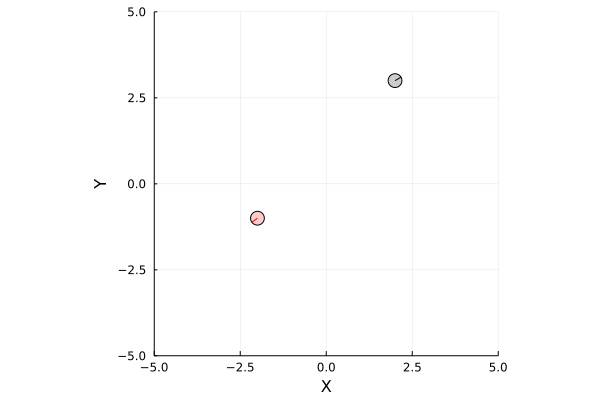

In [95]:
using .RobotWorld
world = RobotWorld.World()

robot1 = RobotWorld.IdealRobot([2, 3, pi/6], :black, 0.2)
robot2 = RobotWorld.IdealRobot([-2, -1, pi/5*6], :red, 0.2)

RobotWorld.append(world, robot1)
RobotWorld.append(world, robot2)
RobotWorld.draw(world)